In [3]:
import jax.ffi as ffi

In [4]:
import jax, jaxlib
print("jax:", jax.__version__, "jaxlib:", jaxlib.__version__)
print("has jax.ffi?", hasattr(jax, "ffi"))
import jax_finufft
from jax_finufft import nufft2
print("jax-finufft OK")


jax: 0.7.1 jaxlib: 0.7.1
has jax.ffi? True
jax-finufft OK


In [1]:
import jax, jaxlib
print("jax:", jax.__version__, "jaxlib:", jaxlib.__version__)


jax: 0.7.1 jaxlib: 0.7.1


In [2]:
import sys, jax, jaxlib
print("python:", sys.executable)
print("jax versions:", jax.__version__, jaxlib.__version__)
print("jax file:", jax.__file__)


python: /Users/ree/miniconda3/envs/py/bin/python
jax versions: 0.7.1 0.7.1
jax file: /Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/jax/__init__.py


In [91]:
# Benchmark: Numba (direct sum) vs JAX + jax-finufft (type-2 NUFFT)
# ---------------------------------------------------------------
# - Correctness check with sigma=0 (deterministic)
# - Speed test with sigma>0 (independent RNGs; timing-only)
#
# You can switch to GPU JAX if available by installing the CUDA wheels.
# Optional fairness knobs are near the bottom (problem sizes, eps, repeats).

import os, time, math
import numpy as np
from numba import njit, prange

import jax
import jax.numpy as jnp
from jax_finufft import nufft2
jax.config.update("jax_enable_x64", True) # Enable float64 in JAX for tight agreement

# ----------------------------
# Original Numba kernel (your baseline)
# ----------------------------
@njit(parallel=True, fastmath=True, cache=True)
def for_loop_tracer_numba(K, ens, L, N, dt, x, y, KX_flat, KY_flat, psi_hat_flat, sigma_xy):
    KX_flat_c = KX_flat  # assume contiguous before call
    KY_flat_c = KY_flat
    invK2 = 1.0 / (K * K)
    twopi = 2.0 * np.pi
    sdt = math.sqrt(dt) * sigma_xy

    for e in prange(ens):
        for i in range(1, N+1):
            # Build exp(L x K^2) and do matvecs (heavy!)
            exp_term = np.exp(1j * x[e, :, i-1][:, None] @ KX_flat_c[None, :]
                              + 1j * y[e, :, i-1][:, None] @ KY_flat_c[None, :])

            uk = (psi_hat_flat[e, i-1, :] * (1j) * KY_flat)
            vk = (psi_hat_flat[e, i-1, :] * (-1j) * KX_flat)

            u = np.real(exp_term @ uk) * invK2
            v = np.real(exp_term @ vk) * invK2

            x[e, :, i] = x[e, :, i-1] + u * dt + np.random.randn(L) * sdt
            y[e, :, i] = y[e, :, i-1] + v * dt + np.random.randn(L) * sdt
            x[e, :, i] = np.mod(x[e, :, i], twopi)
            y[e, :, i] = np.mod(y[e, :, i], twopi)
    return x, y

# ----------------------------
# JAX + jax-finufft kernel
# ----------------------------
def for_loop_tracer(
    K, ens, L, N, dt, x, y, psi_hat, sigma_xy, key, eps=1e-9,
):
    # decide real dtype from complex dtype
    ctype = jnp.asarray(psi_hat).dtype
    rtype = jnp.float64 if ctype == jnp.complex128 else jnp.float32

    # JAX scalars
    dt_r   = jnp.asarray(dt, dtype=rtype)
    sig_r  = jnp.asarray(sigma_xy, dtype=rtype)
    twopi  = jnp.asarray(2 * jnp.pi, dtype=rtype)
    invK2  = jnp.asarray(1.0 / (K * K), dtype=rtype)
    sdt    = jnp.sqrt(dt_r) * sig_r

    # Initial positions
    x0 = jnp.asarray(x[:, :, 0], dtype=rtype)
    y0 = jnp.asarray(y[:, :, 0], dtype=rtype)

    # Wavenumbers in FFT order (JAX fftfreq)
    k_fft = (jnp.fft.fftfreq(K) * K).astype(rtype)
    k_nat = jnp.fft.fftshift(k_fft)     
    kx, ky = jnp.meshgrid(k_nat, k_nat)

    # Time-major psi
    psi_seq = jnp.swapaxes(jnp.asarray(psi_hat), 0, 1) # (N, ens, K, K)

    def uv_one(psi_e, x_e, y_e):
        psi_e = jnp.fft.fftshift(psi_e, axes=(0, 1))
        uhat = 1j * ky * psi_e
        vhat = -1j * kx * psi_e
        # xx = ((x_e + jnp.pi) % (2 * jnp.pi)) - jnp.pi  # [-pi, pi)
        # yy = ((y_e + jnp.pi) % (2 * jnp.pi)) - jnp.pi
        xx = x_e % (2 * jnp.pi)
        yy = y_e % (2 * jnp.pi)
        u = nufft2(uhat, yy, xx, iflag=1, eps=eps).real * invK2
        v = nufft2(vhat, yy, xx, iflag=1, eps=eps).real * invK2
        return u, v

    uv_batched = jax.vmap(uv_one, in_axes=(0, 0, 0), out_axes=(0, 0))

    def step(carry, psi_t):
        x_t, y_t, key_t = carry
        u_t, v_t = uv_batched(psi_t, x_t, y_t)
        key_t, kxkey, kykey = jax.random.split(key_t, 3)
        xi_x = jax.random.normal(kxkey, shape=x_t.shape, dtype=rtype)
        xi_y = jax.random.normal(kykey, shape=y_t.shape, dtype=rtype)
        x_new = (x_t + dt_r * u_t + sdt * xi_x) % twopi
        y_new = (y_t + dt_r * v_t + sdt * xi_y) % twopi
        return (x_new, y_new, key_t), (x_new, y_new)

    carry0 = (x0, y0, key)
    (xf, yf, _), (xs_hist, ys_hist) = jax.lax.scan(step, carry0, psi_seq[:-1])
    xs_hist = jnp.transpose(xs_hist, (1, 2, 0)) 
    ys_hist = jnp.transpose(ys_hist, (1, 2, 0))
    x_out = jnp.concatenate([x0[:, :, None], xs_hist], axis=-1)
    y_out = jnp.concatenate([y0[:, :, None], ys_hist], axis=-1)
    return x_out, y_out

# keep the same jit wrapper
for_loop_tracer = jax.jit(
    for_loop_tracer,
    static_argnums=(0, 1, 2, 3),      # K, ens, L, N
    static_argnames=("eps",),         # make eps compile-time static
)

# ----------------------------
# Helpers to build test data
# ----------------------------
def make_k_arrays(K):
    Kx = np.fft.fftfreq(K) * K
    Ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(Kx, Ky)
    KX_flat = KX.flatten()
    KY_flat = KY.flatten()
    KX_flat = KX_flat.astype(np.complex128)
    KY_flat = KY_flat.astype(np.complex128)

    return KX_flat, KY_flat
    
def init_positions(ens, L, N, seed=0, dtype=np.float64):
    rng = np.random.default_rng(seed)
    x0 = rng.uniform(0.0, 2*np.pi, size=(ens, L)).astype(dtype)
    y0 = rng.uniform(0.0, 2*np.pi, size=(ens, L)).astype(dtype)
    x = np.zeros((ens, L, N+1), dtype=dtype)
    y = np.zeros_like(x)
    x[:, :, 0] = x0
    y[:, :, 0] = y0
    return x, y

# ----------------------------
# Timing utilities
# ----------------------------
def rms(a): return math.sqrt(np.mean(a*a))

def timeit_py(fn, *args, repeats=3, **kw):
    fn(*args, **kw)  # warm-up
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kw)
        ts.append(time.perf_counter() - t0)
    return min(ts)

def timeit_jax(fn, *args, repeats=3, **kw):
    # Warm-up & compile
    out = fn(*args, **kw)
    # Block to exclude compilation time from timing
    if isinstance(out, tuple):
        jax.block_until_ready(out[0])
    else:
        jax.block_until_ready(out)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = fn(*args, **kw)
        # Ensure compute finished
        if isinstance(out, tuple):
            jax.block_until_ready(out[0])
        else:
            jax.block_until_ready(out)
        ts.append(time.perf_counter() - t0)
    return min(ts)

# ----------------------------
# Benchmark + correctness
# ----------------------------
# if __name__ == "__main__":
#     # Optional: control CPU threads (helpful for fair runs)
#     # os.environ["OMP_NUM_THREADS"] = "1"   # limit BLAS/NumPy threads used by Numba path
#     main()
# Problem sizes (tune these)
K   = 128         # grid modes per axis
L   = 1024       # particles
N   = 10         # time steps
ens = 1          # ensembles
dt  = 2e-3

# Accuracy & repeats
eps_nufft = 1e-9
repeats   = 3

# Build data
psi4 = psi_k_t1[..., 0] # (ens, N, K, K)
psi_flat = np.reshape(psi4, (ens, N+1, -1))

KX_flat, KY_flat = make_k_arrays(K)

# Init positions
x_num, y_num = init_positions(ens, L, N, seed=2, dtype=np.float64)
x_jax, y_jax = x_num.copy(), y_num.copy()

# Ensure contiguity for Numba inputs
KX_flat = np.ascontiguousarray(KX_flat)
KY_flat = np.ascontiguousarray(KY_flat)
psi_flat = np.ascontiguousarray(psi_flat)

# ---------- Correctness (σ = 0) ----------
sigma_xy = 0.0

xN, yN = for_loop_tracer_numba(K, ens, L, N, dt,
                               x_num.copy(), y_num.copy(), KX_flat, KY_flat, psi_flat, sigma_xy)
key = jax.random.PRNGKey(0)  # unused when sigma=0, but required by API
xJ, yJ = for_loop_tracer(K, ens, L, N, dt,
                                        x_jax.copy(), y_jax.copy(), psi4, sigma_xy, key, eps=eps_nufft)

# Bring JAX -> NumPy
xJ = np.array(xJ); yJ = np.array(yJ)

# Compare modulo 2π
twopi = 2*np.pi
diff_x = (xN - xJ + np.pi) % (twopi) - np.pi
diff_y = (yN - yJ + np.pi) % (twopi) - np.pi

print("=== Correctness (σ=0) ===")
print(f"max |Δx| = {np.max(np.abs(diff_x)):.3e},  RMS |Δx| = {rms(diff_x):.3e}")
print(f"max |Δy| = {np.max(np.abs(diff_y)):.3e},  RMS |Δy| = {rms(diff_y):.3e}")

# ---------- Speed (σ > 0) ----------
sigma_xy_speed = 0.2

# Fresh copies
x1, y1 = init_positions(ens, L, N, seed=3, dtype=np.float64)
x2, y2 = x1.copy(), y1.copy()

t_num = timeit_py(for_loop_tracer_numba, K, ens, L, N, dt,
                  x1, y1, KX_flat, KY_flat, psi_flat, sigma_xy_speed, repeats=repeats)

key = jax.random.PRNGKey(123)
t_jax = timeit_jax(for_loop_tracer, K, ens, L, N, dt,
                   x2, y2, psi4, sigma_xy_speed, key, eps=eps_nufft, repeats=repeats)

steps = ens * N
print("\n=== Speed ===")
print(f"Numba        : {t_num:.3f} s  (per step ~ {1e3*t_num/steps:.2f} ms)")
print(f"JAX + FINUFFT: {t_jax:.3f} s  (per step ~ {1e3*t_jax/steps:.2f} ms)")
print(f"Speedup ≈ {t_num / t_jax:.2f}×")


kxkey = [3186719485 3840466878]
kxkey = [3126261553 3539587250]
kxkey = [3355082076  543352446]
kxkey = [2669013773 1546418196]
kxkey = [3146291238 4114776201]
kxkey = [ 604427992 2136611236]
kxkey = [1542825469 2269351366]
kxkey = [3054290234  735097881]
kxkey = [2960067817 2974860327]
kxkey = [2505311674 3315432209]
=== Correctness (σ=0) ===
max |Δx| = 1.420e-10,  RMS |Δx| = 2.119e-11
max |Δy| = 1.227e-10,  RMS |Δy| = 2.268e-11
kxkey = [925083257 785867247]
kxkey = [417667310   2962973]
kxkey = [  81366922 2937929344]
kxkey = [ 444961106 1251040734]
kxkey = [1111569872  878452662]
kxkey = [ 716588949 4113028476]
kxkey = [2974122469  791914111]
kxkey = [3576521184 1550172231]
kxkey = [2049499597 1098877349]
kxkey = [2654013571 1584210542]
kxkey = [925083257 785867247]
kxkey = [417667310   2962973]
kxkey = [  81366922 2937929344]
kxkey = [ 444961106 1251040734]
kxkey = [1111569872  878452662]
kxkey = [ 716588949 4113028476]
kxkey = [2974122469  791914111]
kxkey = [3576521184 1550172231

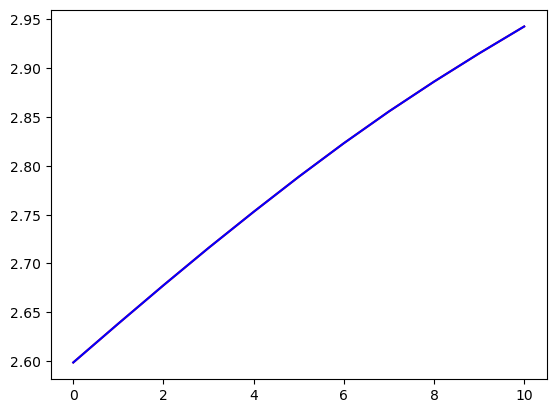

In [69]:
import matplotlib.pyplot as plt

plt.plot(yN[0,0,:], 'r')
plt.plot(yJ[0,0,:], 'b')


In [75]:
jax.random.normal(0, shape=(1,))

TypeError: JAX encountered invalid PRNG key data: expected key_data to have ndim, shape, and dtype attributes. Got 0

In [88]:
key = jax.random.PRNGKey(0)
key_t, kxkey, kykey = jax.random.split(key, 3)

In [89]:
key_t

Array([2467461003,  428148500], dtype=uint32)

In [94]:
np.random.randint(-2147483648, 2147483648)

-2131094139

In [62]:
x_num[0,0,0]

1.6437575180951982

In [61]:
yJ[0,0,0]

1.6437575180951982

In [46]:
import numpy as np
import jax
import jax.numpy as jnp
from jax_finufft import nufft2

# for tight agreement in float64
jax.config.update("jax_enable_x64", True)

def compare_nufft_ifft2(K=64, n_trials=3, seed=0, eps=1e-12, verbose=True):
    """
    Compare jax-finufft nufft2 (type-2) to numpy.fft.ifft2 on a uniform KxK grid.
    Returns (max_abs_err, rms_err) averaged over trials (also prints per-trial).
    """
    rng = np.random.default_rng(seed)

    # Uniform grid points in [0, 2π)
    idx = jnp.arange(K, dtype=jnp.float64)
    xx, yy = jnp.meshgrid(2*jnp.pi*idx/K, 2*jnp.pi*idx/K, indexing="xy")
    x_flat = xx.ravel(order="F")
    y_flat = yy.ravel(order="F")

    max_errs = []
    rms_errs = []

    for t in range(n_trials):
        # Random complex spectrum in NumPy FFT order
        C_fft = (rng.standard_normal((K, K)) + 1j * rng.standard_normal((K, K))).astype(np.complex128)

        # Reference: NumPy IFFT (note: includes 1/K^2 normalization)
        f_ifft = np.fft.ifft2(C_fft)  # shape (K, K), complex128

        # NUFFT expects NATURAL mode order: [-K/2..K/2-1] along each axis
        C_nat = np.fft.fftshift(C_fft, axes=(0, 1))  # (K,K) complex128
        # C_nat = C_fft  # (K,K) complex128

        # Evaluate NUFFT on the same uniform grid
        # nufft2: grid coeffs -> values at points; use iflag=+1 to match ifft2 sign
        f_nufft_flat = nufft2(jnp.asarray(C_nat), y_flat, x_flat, iflag=+1, eps=eps)
        f_nufft = np.array(f_nufft_flat).reshape(K, K, order="F") / (K * K)  # apply 1/K^2

        # Errors
        diff = f_nufft - f_ifft
        max_err = np.max(np.abs(diff))
        rms_err = np.sqrt(np.mean(np.abs(diff) ** 2))

        max_errs.append(max_err)
        rms_errs.append(rms_err)

        if verbose:
            print(f"[trial {t+1}/{n_trials}]  max|Δ|={max_err:.3e}   RMS|Δ|={rms_err:.3e}")

    # Aggregate (not strictly necessary, but handy if n_trials>1)
    max_avg = float(np.mean(max_errs))
    rms_avg = float(np.mean(rms_errs))
    if verbose and n_trials > 1:
        print(f"\nAveraged over {n_trials} trials:")
        print(f"  mean max|Δ| = {max_avg:.3e}")
        print(f"  mean RMS|Δ| = {rms_avg:.3e}")
    return max_avg, rms_avg

if __name__ == "__main__":
    # Try a couple sizes; NUFFT is approximate, so use a reasonably tight eps.
    for K in (32, 64, 128):
        print(f"\n=== K = {K} ===")
        compare_nufft_ifft2(K=K, n_trials=3, eps=1e-12)



=== K = 32 ===
[trial 1/3]  max|Δ|=2.521e-13   RMS|Δ|=1.034e-13
[trial 2/3]  max|Δ|=2.602e-13   RMS|Δ|=1.008e-13
[trial 3/3]  max|Δ|=2.825e-13   RMS|Δ|=1.017e-13

Averaged over 3 trials:
  mean max|Δ| = 2.649e-13
  mean RMS|Δ| = 1.020e-13

=== K = 64 ===
[trial 1/3]  max|Δ|=1.799e-13   RMS|Δ|=5.542e-14
[trial 2/3]  max|Δ|=1.923e-13   RMS|Δ|=5.725e-14
[trial 3/3]  max|Δ|=1.632e-13   RMS|Δ|=5.653e-14

Averaged over 3 trials:
  mean max|Δ| = 1.785e-13
  mean RMS|Δ| = 5.640e-14

=== K = 128 ===
[trial 1/3]  max|Δ|=8.327e-14   RMS|Δ|=2.759e-14
[trial 2/3]  max|Δ|=7.686e-14   RMS|Δ|=2.709e-14
[trial 3/3]  max|Δ|=9.570e-14   RMS|Δ|=2.725e-14

Averaged over 3 trials:
  mean max|Δ| = 8.527e-14
  mean RMS|Δ| = 2.731e-14


In [37]:
k_fft = (jnp.fft.fftfreq(K) * K)
k_nat = jnp.fft.fftshift(k_fft) 

In [38]:
k_nat

Array([-64., -63., -62., -61., -60., -59., -58., -57., -56., -55., -54.,
       -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43.,
       -42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32.,
       -31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.], dtype=float64)

In [39]:
k_fft

Array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63., -64., -63.,
       -62., -61., -60., -59., -58., -57., -56., -55., -54., -53., -52.,
       -51., -50., -49., -48., -47., -46., -45., -44., -43., -42., -41.,
       -40., -39., -38., -37., -36., -35., -34., -33., -32., -31., -30.,
       -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,
        -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.], dtype=float64)

In [9]:
psi4 = psi_k_t1[..., 0]
psi4.shape

(1, 11, 128, 128)

In [13]:
np.reshape(psi4, (1, 10+1, -1)).shape

(1, 11, 16384)

In [4]:
import numpy as np
from numba import jit
from QG import QG
from Lagrangian_tracer import Lagrange_tracer_model
from time import time
'''
require rocket-fft for numba to be aware of np.fft
!pip install rocket-fft 
'''
def generate_topo(N=128, alpha=4.0):
    '''generate a gaussian random field as topography'''
    kx = np.fft.fftfreq(N).reshape(-1, 1)
    ky = np.fft.fftfreq(N).reshape(1, -1)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-6  # avoid division by zero
    spectrum = 1.0 / k**alpha # Power-law spectrum: 1 / k^alpha
    noise = np.random.normal(size=(N, N)) + 1j * np.random.normal(size=(N, N))
    fft_field = noise * np.sqrt(spectrum)
    field = np.fft.ifft2(fft_field).real
    field -= np.mean(field)
    field /= np.std(field)
    return field

class QG_tracer:
    def __init__(self, K=128, kd=10, kb=np.sqrt(22), U=1, r=9, nu=1e-12, H=40, topo=None, sigma_xy=0.1, style='square'):
        Kx = np.fft.fftfreq(K) * K
        Ky = np.fft.fftfreq(K) * K
        KX, KY = np.meshgrid(Kx, Ky)

        # Initialize topography
        if topo is None:
            dx = 2 * np.pi / K
            X, Y = np.meshgrid(np.arange(0, 2*np.pi, dx), np.arange(0, 2*np.pi, dx))
            topo = H * (np.cos(X) + 2 * np.cos(2 * Y))
            topo -= np.mean(topo)  # subtracting the mean to center the topography
        hk = np.fft.fft2(topo)

        # Initialize additional variables for the simulation
        K_square = KX**2 + KY**2
        q2psi = -1 / (K_square * (K_square + kd**2))[:,:,None,None] * (np.eye(2) * K_square[:, :, None, None] + kd**2/2)
        q2psi[0,0,:,:] = 0
        q2psi = q2psi.astype(np.complex128)
        subtract_hk = np.zeros(((K,K,2)), dtype=complex)
        subtract_hk[:,:,1] = hk

        self.flow_model = QG(K, kd, kb, U, r, nu, H, topo)
        self.tracer_model = Lagrange_tracer_model(K, sigma_xy, style)
        self.q2psi = q2psi
        self.subtract_hk = subtract_hk

    def forward_ens(self, ens, Nt=1, dt=1e-3, qp_ens=None, L=1, x0=None, y0=None):
        '''
        qp_ens: array of shape (ens, K, K, 2)
        x0, y0: arrays of shape (ens, L)
        '''
        K = qp_ens.shape[1]
        flow_model = self.flow_model
        tracer_model = self.tracer_model
        q2psi = self.q2psi
        subtract_hk = self.subtract_hk

        # run flow model
        qp_history = flow_model.forward_ens(ens, Nt, dt, qp_ens)
        q_hat_history = np.fft.fft2(qp_history, axes=(2,3))

        # q to psi
        q_vec = q_hat_history - subtract_hk
        psi_hat_history = (q2psi @ q_vec[:,:,:,:,:,None])[:,:,:,:,:,0] # of shape (ens,Nt+1,K,K,2)

        # # psi to velocity
        # u = np.real(np.fft.ifft2(psi_hat_history[:, -1, :, :, :] * 1j * KY[:, :, None], axes=(1,2)))
        # v = np.real(np.fft.ifft2(psi_hat_history[:, -1, :, :, :] * (-1j) * KX[:, :, None], axes=(1,2)))

        # run tracer model
        x, y = tracer_model.forward_ens(ens, L, Nt, dt, x0, y0, psi_hat_history[:, :, :, :, 0]) # of shape (ens,L,Nt+1)

        return psi_hat_history, x, y, qp_history#, u, v

    def forward_flow(self, ens=1, Nt=1, dt=1e-3, qp_ens=None):
        '''
        qp_ens: array of shape (ens, K, K, 2)
        '''
        flow_model = self.flow_model
        q2psi = self.q2psi
        subtract_hk = self.subtract_hk

        # run flow model
        qp_history = flow_model.forward_ens(ens, Nt, dt, qp_ens) # of shape (ens, Nt+1, K, K, 2)
        q_hat_history = np.fft.fft2(qp_history, axes=(2,3))

        # q to psi
        q_vec = q_hat_history - subtract_hk
        psi_hat_history = (q2psi @ q_vec[:,:,:,:,:,None])[:,:,:,:,:,0] # of shape (ens,Nt+1,K,K,2)

        return qp_history, psi_hat_history


if __name__ == "__main__": 
    np.random.seed(0)

    # ---------- QG model parameters ------------
    K = 128 # Number of points (also Fourier modes) in each direction
    kd = 10 # Nondimensional deformation wavenumber
    kb = np.sqrt(22) # Nondimensional beta wavenumber, beta = kb^2 
    U = 1 # Zonal shear flow
    r = 9 # Nondimensional Ekman friction coefficient
    nu = 1e-12 # Coefficient of biharmonic vorticity diffusion
    H = 40 # Topography parameter
    dt = 2e-3 # Time step size
    warm_up = 10 # Warm-up time steps
    Nt = 100 + warm_up # Number of time steps

    # ------- Tracer observation parameters -------
    L = 1024 # Number of tracers
    sigma_xy = 0.1 # Tracer observation noise std (in sde)
    dt_obs = 4e-2 # Observation time interval
    obs_freq = int(dt_obs / dt) # Observation frequency
    Nt_obs = int((Nt - warm_up) / obs_freq + 1) # Number of observations saved

    # -------------- initialization ---------------
    # topo = generate_topo(K, 4) # generate topography
    # topo = H * topo
    dx = 2 * np.pi / K
    X, Y = np.meshgrid(np.arange(0, 2*np.pi, dx), np.arange(0, 2*np.pi, dx))
    topo = H * (np.cos(X) + 2 * np.cos(2 * Y))
    topo -= np.mean(topo)  # subtracting the mean to center the topography
    qp = np.zeros((K, K, 2))
    qp[:, :, 1] = 10 * np.random.randn(K, K)
    qp[:, :, 1] -= np.mean(qp[:, :, 1])
    qp[:, :, 0] = qp[:, :, 1]
    psi_k_t = np.zeros((Nt_obs, K, K, 2), dtype=complex)
    model = QG_tracer(K=K, kd=kd, kb=kb, U=U, r=r, nu=nu, topo=topo, sigma_xy=sigma_xy)
    # model = QG_tracer(K=K, kd=kd, kb=kb, U=U, r=r, nu=nu, H=H, sigma_xy=sigma_xy)
    x_t = np.zeros((Nt_obs, L))
    y_t = np.zeros((Nt_obs, L))
    x0 = np.pi + 0.1 * np.random.randn(L) # np.random.uniform(0, 2*np.pi, L)
    y0 = np.pi + 0.1 * np.random.randn(L) # np.random.uniform(0, 2*np.pi, L)
    x_t[0, :] = x0
    y_t[0, :] = y0

    # warm up
    qp_t, psi_k_t1 = model.forward_flow(ens=1, Nt=warm_up, dt=dt, qp_ens=qp[None,:,:,:])

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_40085/148327773.py:40: RuntimeWarning: divide by zero encountered in divide
  q2psi = -1 / (K_square * (K_square + kd**2))[:,:,None,None] * (np.eye(2) * K_square[:, :, None, None] + kd**2/2)
/Users/ree/Documents/Research/Proj_2_DAnPE_CGKN/code/QG.py:132: RuntimeWarning: divide by zero encountered in divide
  q2psi = -1 / (K_square * (K_square + kd**2))[:,:,None,None] * (np.eye(2) * K_square[:, :, None, None] + kd**2/2)


In [16]:
psi_t.shape

(6, 64, 64, 2)

In [13]:
import numpy as np
# file = np.load('../data/qg_data_topo2_L512.npz')
file = np.load('./qg_data_test.npz')
psi_t = file['psi_truth']
xy_obs = file['xy_obs']

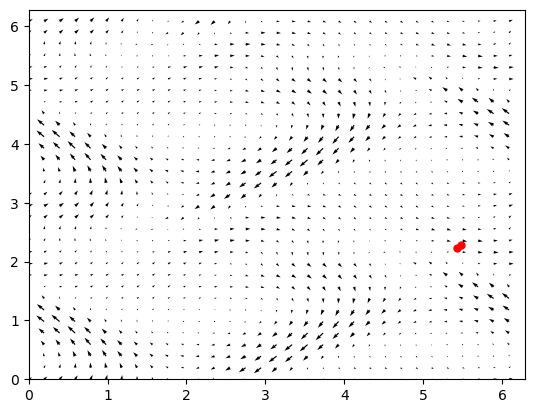

In [17]:
psi_k_t = np.fft.fft2(psi_t[:, :, :, :], axes=(1,2))
x_t = xy_obs[:, :, 0]
y_t = xy_obs[:, :, 1]

Nt = 5
Nx = 64
Kx = np.fft.fftfreq(Nx) * Nx
Ky = np.fft.fftfreq(Nx) * Nx
KX, KY = np.meshgrid(Kx, Ky)
ut = np.real(np.fft.ifft2(psi_k_t * 1j * KY[:,:,None], axes=(1,2)))
vt = np.real(np.fft.ifft2(psi_k_t * (-1j) * KX[:,:,None], axes=(1,2)))

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

K = 64
L = 2
interv = 2
# animation of tracers on flow field
tracer_x = x_t[:, :L]
tracer_y = y_t[:, :L]
velocity_ut = ut[:, ::interv, ::interv, 0]
velocity_vt = vt[:, ::interv, ::interv, 0]

# Set up the figure and axis for plotting
fig, ax = plt.subplots()
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi])
xgrid = np.linspace(0, 2*np.pi, int(K/interv), endpoint=False)
ygrid = np.linspace(0, 2*np.pi, int(K/interv), endpoint=False)
X, Y = np.meshgrid(xgrid, ygrid)
quiver = ax.quiver(X, Y, velocity_ut[0,:,:], velocity_vt[0,:,:])#, color='lightgrey', scale=10)
tracer, = ax.plot([], [], 'ro', markersize=5)  # Initial empty tracer plot

# Initialization function for FuncAnimation
def init():
    tracer.set_data([], [])
    quiver.set_UVC(velocity_ut[0,:,:], velocity_vt[0,:,:])
    return tracer, quiver

# Update function for FuncAnimation
def update(frame):
    # tracer.set_data(tracer_x[frame], tracer_y[frame])
    all_tracers_x = tracer_x[frame, :]
    all_tracers_y = tracer_y[frame, :]
    tracer.set_data(all_tracers_x, all_tracers_y)  # Update tracers' position
    quiver.set_UVC(velocity_ut[frame,:,:], velocity_vt[frame,:,:])
    return tracer, quiver

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, Nt+1, 1), init_func=init, blit=False, interval=400)

# Save the animation
ani.save('tracer_flow.gif', writer='pillow', dpi=80)

plt.show()